## Spooky Author Identification

In [1]:
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/vishnukumar10/Spooky_Author_Identification/main/train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


No null values in the dataset

### Length of each input:

In [4]:
df['len'] = df['text'].str.len()
df['comma_count'] = df['text'].str.count(',')
df['scolons_count'] = df['text'].str.count(';')
df['colons_count'] = df['text'].str.count(':')
df['q_marks'] = df['text'].str.count('\?')

In [5]:
stops = set(stopwords.words("english"))
article = ['a', 'an', 'the']
questions = ['What','Why','How','Where','When','Which']

def stopword_counter(x):
    stop_count=0
    for word in x.split():
            if word in stops:
                stop_count=stop_count+1
    return stop_count

def a_counter(x):
    article_count = 0
    for word in x.split():
            if word in article:
                article_count=article_count+1
    return article_count

def q_counter(x):
    q_count = 0
    for word in x.split():
            if word in questions:
                q_count=q_count+1
    return q_count

In [6]:
df['stop_counter'] = df['text'].apply(lambda x: stopword_counter(x))
df['article_counter'] = df['text'].apply(lambda x: a_counter(x))
df['questions_counter'] = df['text'].apply(lambda x: q_counter(x))

## Stopword Elimination 

In [7]:
stops = set(stopwords.words("english"))
def stop_rem(sentence):
    sentence = [char for char in sentence if char not in string.punctuation]
    sentence = ''.join(sentence)
    sentence=[word for word in sentence.split() if word.lower() not in stops]
    sentence=' '.join(sentence)
    return sentence

In [8]:
stop_rem('study studied i was studying')

'study studied studying'

In [9]:
df['CORPUS']=df['text'].apply(stop_rem)
df.head(2)

,id,text,author,len,comma_count,scolons_count,colons_count,q_marks,stop_counter,article_counter,questions_counter,CORPUS
0,id26305,"This process, however, afforded me no means of...",EAP,231,4,2,0,0,16,4,0,process however afforded means ascertaining di...
1,id17569,It never once occurred to me that the fumbling...,HPL,71,0,0,0,0,7,2,0,never occurred fumbling might mere mistake


In this pre-processing stage, we have removed all the stopwords and punctuations and the bag of words model is to be created next to fit into the classification models.

## Feature Engineering

In [10]:
vectorizer=CountVectorizer()
bow=vectorizer.fit_transform(df['CORPUS'])
bow1=pd.DataFrame(bow.toarray(),columns=vectorizer.get_feature_names())

In [11]:
bow1.head()

,aaem,ab,aback,abaft,abandon,abandoned,abandoning,abandonment,abaout,abased,...,æneid,ærial,æronaut,æronauts,ærostation,æschylus,élite,émeutes,οἶδα,υπνος
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
def author1(temp):
    if temp=='EAP':
        return 0
    elif temp=='HPL':
        return 1
    elif temp=='MWS':
        return 2

df['author_final']=df['author'].apply(lambda x: author1(x))

In [13]:
X = bow1.join(df[['len','comma_count','scolons_count','colons_count','q_marks','stop_counter','article_counter','questions_counter']])
y = df['author_final']

In [14]:
X.head()

,aaem,ab,aback,abaft,abandon,abandoned,abandoning,abandonment,abaout,abased,...,οἶδα,υπνος,len,comma_count,scolons_count,colons_count,q_marks,stop_counter,article_counter,questions_counter
0,0,0,0,0,0,0,0,0,0,0,...,0,0,231,4,2,0,0,16,4,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,71,0,0,0,0,7,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,200,4,0,0,0,15,4,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,206,3,0,0,0,11,1,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,174,2,1,0,0,11,2,0


In [15]:
y[5]

2

## Model –Classification; Confusion Matrix, Accuracy, F-Measure

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#Model 1: Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train,y_train)
y_pred=log_model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

C:\Users\vishn\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[1281  135  154]
 [ 457  481  133]
 [ 579  146  550]]
              precision    recall  f1-score   support

           0       0.55      0.82      0.66      1570
           1       0.63      0.45      0.52      1071
           2       0.66      0.43      0.52      1275

    accuracy                           0.59      3916
   macro avg       0.61      0.57      0.57      3916
weighted avg       0.61      0.59      0.58      3916



In [18]:
#Model 2: Decision Tree Classifier
des_model = DecisionTreeClassifier(max_depth=20)
des_model.fit(X_train,y_train)
y_pred=des_model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1116  250  204]
 [ 400  518  153]
 [ 550  256  469]]
              precision    recall  f1-score   support

           0       0.54      0.71      0.61      1570
           1       0.51      0.48      0.49      1071
           2       0.57      0.37      0.45      1275

    accuracy                           0.54      3916
   macro avg       0.54      0.52      0.52      3916
weighted avg       0.54      0.54      0.53      3916



In [19]:
#Model 3: Multinomial Naive Bayes
mnb_model = MultinomialNB(alpha=0.01)
mnb_model.fit(X_train, y_train)
y_pred = mnb_model.predict(X_test)
y_pred_prob = mnb_model.predict_proba(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1238  135  197]
 [  95  897   79]
 [ 130   61 1084]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1570
           1       0.82      0.84      0.83      1071
           2       0.80      0.85      0.82      1275

    accuracy                           0.82      3916
   macro avg       0.82      0.83      0.82      3916
weighted avg       0.82      0.82      0.82      3916



We can see Multinomial NB has outperformed the other models namely logistic regression and Decision Tree classifier by a very high margin with about 82% accuracy.

##  10 fold cross validation and RoC Tests.

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
#Logistic Regression KFold
scores = cross_val_score(log_model, X_train, y_train, cv=10)
print(scores)

C:\Users\vishn\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vishn\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[0.64964901 0.64582004 0.67645182 0.63920817 0.63920817 0.61749681
 0.58109834 0.59067688 0.60855683 0.57024266]


In [22]:
#DTrees KFold
scores = cross_val_score(des_model, X_train, y_train, cv=10)
print(scores)

[0.55647735 0.54945756 0.55201021 0.52745849 0.53384419 0.54980843
 0.53320562 0.52745849 0.5357599  0.53384419]


In [23]:
#MultinomialNB KFold
scores = cross_val_score(mnb_model, X_train, y_train, cv=10)
print(scores)

[0.83216337 0.83024888 0.82705807 0.80332056 0.83141762 0.82630907
 0.81864623 0.83844189 0.83205619 0.82822478]


Multinomial NB has outperformed the other models by the very high margin even in cross validation test.

### ROC Plots

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

In [25]:
def roc_plotting(model):
    y = df['author_final']
    y = label_binarize(y, classes=[0, 1, 2])
    n_classes = y.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

C:\Users\vishn\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vishn\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

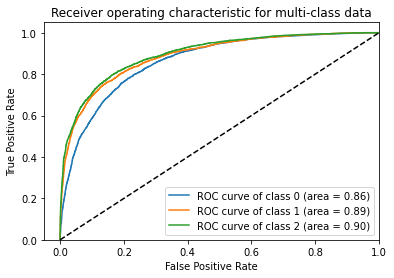

In [26]:
log_model = LogisticRegression()
roc_plotting(log_model)

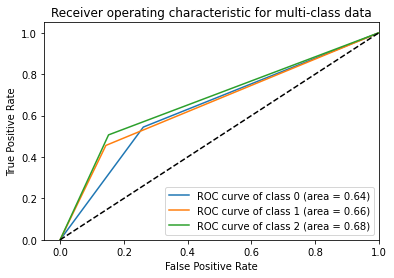

In [27]:
des_model = DecisionTreeClassifier(criterion="entropy")
roc_plotting(des_model)

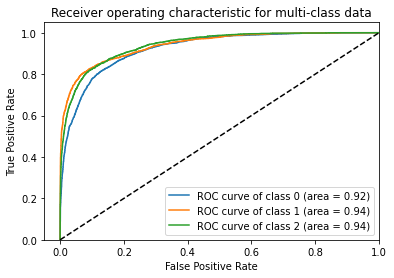

In [28]:
mnb_model = MultinomialNB(alpha=0.01)
roc_plotting(mnb_model)

Multinomial NB has better results with steeper curve and greater area in ROC than the other two classifiers.

## Hypothesis testing (ANOVA) and T-test

#### Null Hypothesis: The styles of the three authors are very similar
#### Alternate Hypothesis: The styles of the three authors are different

In [29]:
df['style'] = df['len']/(df['comma_count']+df['scolons_count']+df['colons_count']+df['q_marks']+df['stop_counter']+df['article_counter']+df['questions_counter']+1)

In [30]:
import scipy.stats as stats

stats.f_oneway(df['style'][df['author_final'] == 0],
               df['style'][df['author_final'] == 1],
               df['style'][df['author_final'] == 2])

F_onewayResult(statistic=127.88174583254772, pvalue=6.627389670535951e-56)

F = variation between sample means / variation within the samples<br>
We see that the P Value is low and is less than 0.05, we reject the null hypothesis. Hence, the styles of the three authors are different.

### T-Test

In [31]:
stats.ttest_ind(df['style'][df['author_final'] == 0],df['style'][df['author_final'] == 1])

Ttest_indResult(statistic=-14.918022272274346, pvalue=6.270904483976752e-50)

In [32]:
stats.ttest_ind(df['style'][df['author_final'] == 0],df['style'][df['author_final'] == 2])

Ttest_indResult(statistic=-2.4800596320932025, pvalue=0.013147758593397707)

In [33]:
stats.ttest_ind(df['style'][df['author_final'] == 1],df['style'][df['author_final'] == 2])

Ttest_indResult(statistic=12.666667703146517, pvalue=1.572812628404093e-36)

The p values are low and less than 0.05. Hence we reject the null hypothesis. So, each of the authors are different from one other. 

### Student T-Test

In [34]:
df1 = df.sample(30)
stats.ttest_ind(df1['style'][df1['author_final'] == 0],df1['style'][df['author_final'] == 1])

Ttest_indResult(statistic=-2.3901236691430494, pvalue=0.027360983075177658)

In [35]:
stats.ttest_ind(df1['style'][df1['author_final'] == 0],df1['style'][df['author_final'] == 2])

Ttest_indResult(statistic=-1.3403136031080836, pvalue=0.19382208381621613)

In [36]:
stats.ttest_ind(df1['style'][df1['author_final'] == 1],df1['style'][df['author_final'] == 2])

Ttest_indResult(statistic=1.8042670702926302, pvalue=0.09439781686197063)

We have obtain varied p value results from the student t-test.